In [2]:
import numpy as np
import pandas as pd
import os 
import matplotlib.pyplot as plt

In [7]:
# Function to convert Euler angles to a rotation matrix
def euler_to_rotation_matrix(roll, pitch, yaw):
    roll = np.deg2rad(roll)
    pitch = np.deg2rad(pitch)
    yaw = np.deg2rad(yaw)

    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    
    R_y = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    
    R_z = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    
    R = R_z @ R_y @ R_x
    return R





In [19]:
def zero_velocity_update_single_axis(acc_data, gyro_data, acc_threshold, gyro_threshold, window_size):
    stationary = np.zeros(len(acc_data), dtype=int)
    for i in range(window_size, len(acc_data) - window_size):
        acc_window = acc_data[i-window_size:i+window_size]
        acc_mean = np.mean(acc_window, axis=0)
        if abs(acc_mean) > acc_threshold:
            gyro_window = gyro_data[i-window_size:i+window_size]
            gyro_mean = np.std(gyro_window, axis=0)
            if abs(gyro_mean) > gyro_threshold:
                stationary[i-window_size:i+window_size] = 20
    return stationary




In [29]:
def zero_velocity_update(acc_data, gyro_data, acc_threshold, gyro_threshold, window_size):
    stationary = np.zeros(len(acc_data), dtype=int)
    for i in range(window_size, len(acc_data) - window_size):
        acc_window = acc_data[i-window_size:i+window_size]
        acc_mean = np.mean(acc_window, axis=0)
        
        if np.all(np.abs(acc_mean) > acc_threshold):
            gyro_window = gyro_data[i-window_size:i+window_size]
            gyro_mean = np.std(gyro_window, axis=0)
            
            if np.all(np.abs(gyro_mean) > gyro_threshold):
                stationary[i-window_size:i+window_size] = 10
                
    return stationary

time 0       881847736
1       881856069
2       881864402
3       881872735
4       881881068
          ...    
1560    894847216
1561    894855549
1562    894863882
1563    894872215
1564    894880548
Name: SampleTimeFine, Length: 1565, dtype: int64

Adjusted time (in seconds):
0        0.000000
1        0.008333
2        0.016666
3        0.024999
4        0.033332
          ...    
1560    12.999480
1561    13.007813
1562    13.016146
1563    13.024479
1564    13.032812
Name: SampleTimeFine, Length: 1565, dtype: float64
global_acc_data_mean_value [ 0.24860824 -0.43055833 19.78887276]
Maximum displacement: 0.6707238835833969


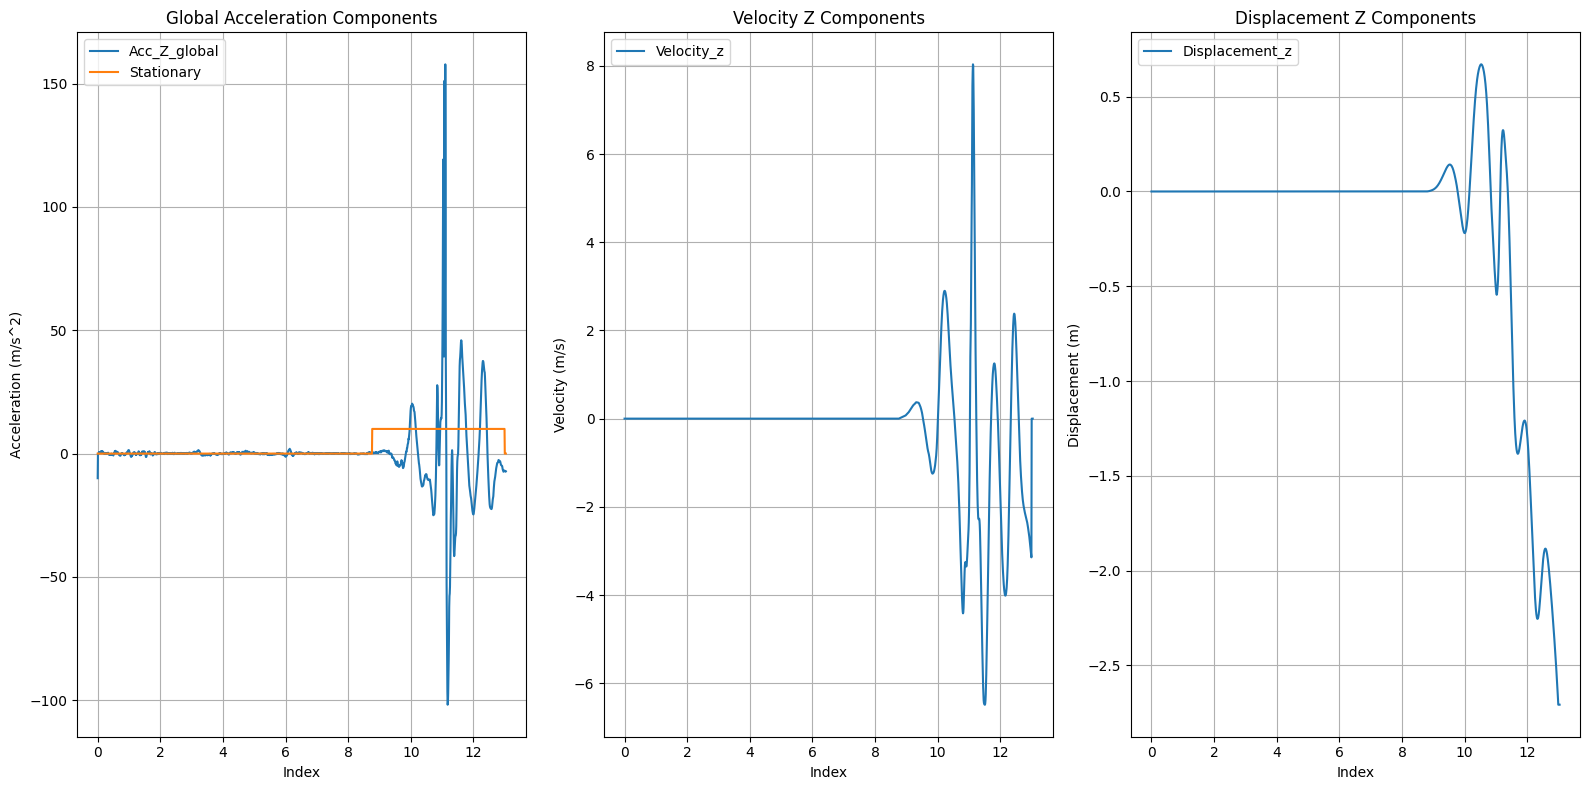

In [107]:
import pandas as pd
import numpy as np
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, firwin
# Load the data from a CSV file
input_csv_path = 'bowl_height3.csv' 
data = pd.read_csv(input_csv_path)

result = data

print("time",data['SampleTimeFine'])

time = data['SampleTimeFine']

initial_time = time[0]
adjusted_time = time - initial_time

adjusted_time_in_seconds = adjusted_time / 1e6

print("\nAdjusted time (in seconds):")
print(adjusted_time_in_seconds)

data['SampleTimeFine'] = adjusted_time_in_seconds

global_acc_data = []

global_acc_data_minus_gravity = []

# Define gravity vector in global coordinate system
gravity_vector = np.array([0, 0, -9.80665])

for index, row in data.iterrows():
    roll = row["Euler_X"]
    pitch = row["Euler_Y"]
    yaw = row["Euler_Z"]
    
    R = euler_to_rotation_matrix(roll, pitch, yaw)
    
    acc_device = np.array([row["Acc_X"], row["Acc_Y"], row["Acc_Z"]])

    acc_global = R @ acc_device

    acc_global_minus_gravity = acc_global - gravity_vector
    
    global_acc_data.append(acc_global)

    global_acc_data_minus_gravity.append(acc_global_minus_gravity)

# to remove the initial offset value
global_acc_data_mean_value = np.mean(global_acc_data_minus_gravity[0:100],axis=0)

# Convert results to a DataFrame
global_acc_data_minus_gravity = np.array(global_acc_data_minus_gravity)
global_acc_df = pd.DataFrame(global_acc_data, columns=["Acc_X_global_origin", "Acc_Y_global_origin", "Acc_Z_global_origin"])
global_acc_df_free = pd.DataFrame(global_acc_data_minus_gravity, columns=["Acc_X_global", "Acc_Y_global", "Acc_Z_global"])

# Combine with original data
result = pd.concat([data, global_acc_df], axis=1)
result = pd.concat([result, global_acc_df_free], axis=1)

print("global_acc_data_mean_value",global_acc_data_mean_value)
result['Acc_X_global'] = result['Acc_X_global'].apply(lambda x: x-global_acc_data_mean_value[0])
result['Acc_Y_global'] = result['Acc_Y_global'].apply(lambda x: x-global_acc_data_mean_value[1])
result['Acc_Z_global'] = result['Acc_Z_global'].apply(lambda x: x-global_acc_data_mean_value[2])

# Define thresholds and window size for ZUPT
acc_threshold = 0.5 # m/s^2, this value can be tuned
gyro_threshold = 0.5  # rad/s, this value can be tuned
window_size = 30  # number of samples, this value can be tuned






Adjusted time (in seconds):
0        0.000000
1        0.008333
2        0.016666
3        0.024999
4        0.033332
          ...    
1996    16.632668
1997    16.641001
1998    16.649334
1999    16.657667
2000    16.666000
Name: SampleTimeFine, Length: 2001, dtype: float64

Adjusted time (in seconds):
0        0.000000
1        0.008333
2        0.016666
3        0.024999
4        0.033332
          ...    
1996    16.632668
1997    16.641001
1998    16.649334
1999    16.657667
2000    16.666000
Name: SampleTimeFine, Length: 2001, dtype: float64

Maximum Z Position Details:
Initial Position Z: 0.0
Max Z Position: 160031.9398324665


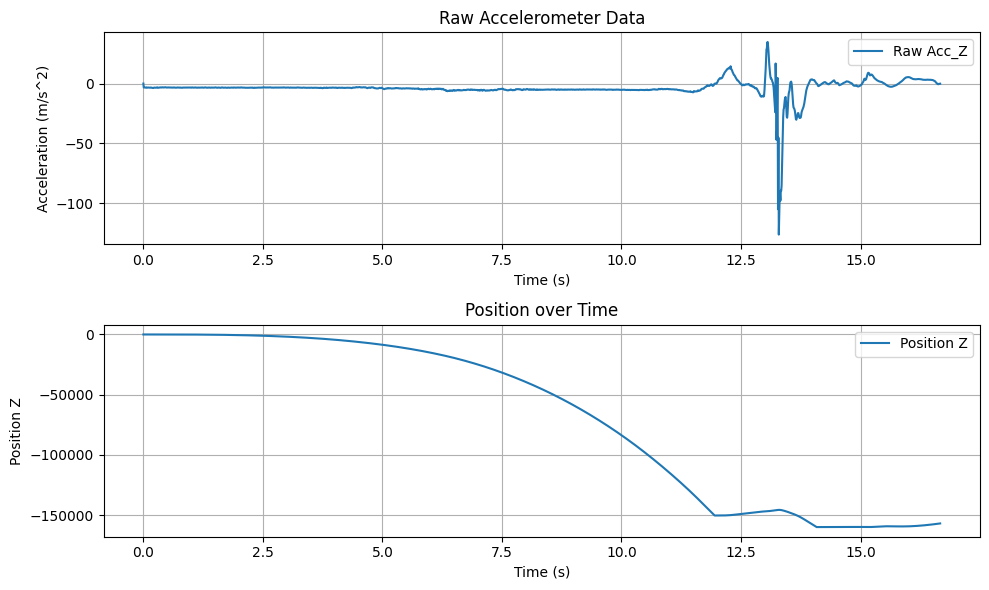

In [53]:
import pandas as pd
import numpy as np
from scipy.integrate import cumulative_trapezoid
import matplotlib.pyplot as plt

# Load IMU data
data = pd.read_csv('bowl_height3.csv')

# Adjust the SampleTimeFine to start from zero and convert to seconds
time = data['SampleTimeFine']

initial_time = time[0]
adjusted_time = time - initial_time

# Convert to seconds if the original time is in microseconds
adjusted_time_in_seconds = adjusted_time / 1e6

print("\nAdjusted time (in seconds):")
print(adjusted_time_in_seconds)

data['SampleTimeFine'] = adjusted_time_in_seconds

# Print the adjusted time
print("\nAdjusted time (in seconds):")
print(adjusted_time_in_seconds)

# Assuming data['Acc_Z'] is your raw z-axis accelerometer data
accel_z = data['Acc_Z'].values

# Define ZUPT parameters
accel_threshold = 0.1  # Threshold for stationary detection (adjust as needed)
stationary_indices = np.abs(accel_z) < accel_threshold

# Correct velocity using ZUPT
velocity_z = np.zeros_like(accel_z)
for i in range(1, len(accel_z)):
    if stationary_indices[i]:
        velocity_z[i] = 0.0  # Reset velocity to zero during stationary periods
    else:
        velocity_z[i] = velocity_z[i-1] + (accel_z[i] + accel_z[i-1]) / 2 * adjusted_time_in_seconds[i]

# Integrate to get position
position_z = cumulative_trapezoid(velocity_z, adjusted_time_in_seconds, initial=0)

# Correct for the initial position
initial_position_z = position_z[0]
corrected_position_z = position_z - initial_position_z

data['velocity_z'] = velocity_z
data['position_z'] = corrected_position_z

# Print some diagnostic information
print("\nMaximum Z Position Details:")
print(f"Initial Position Z: {initial_position_z}")
max_z_position = abs(data['position_z']).max()
print(f"Max Z Position: {max_z_position}")

# Plotting filtered accelerometer data and position over time
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(adjusted_time_in_seconds, accel_z, label='Raw Acc_Z')
plt.xlabel('Time (s)')
plt.ylabel('Acceleration (m/s^2)')
plt.title('Raw Accelerometer Data')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(adjusted_time_in_seconds, data['position_z'], label='Position Z')
plt.xlabel('Time (s)')
plt.ylabel('Position Z')
plt.title('Position over Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [99]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, firwin
from scipy.integrate import cumulative_trapezoid

# Load IMU data
data = pd.read_csv('bowl_height3.csv')

# Adjust the SampleTimeFine to start from zero and convert to seconds
time = data['SampleTimeFine'].values
initial_time = time[0]
adjusted_time = time - initial_time
adjusted_time_in_seconds = adjusted_time / 1e6

data['SampleTimeFine'] = adjusted_time_in_seconds

# Print the adjusted time
print("\nAdjusted time (in seconds):")
print(adjusted_time_in_seconds)

def fir_lowpass(cutoff, fs, numtaps=101):
    nyquist = 0.5 * fs
    cutoff_norm = cutoff / nyquist
    taps = firwin(numtaps, cutoff_norm)
    return taps

def lowpass_filter(data, cutoff=5, fs=50, numtaps=101):
    taps = fir_lowpass(cutoff, fs, numtaps=numtaps)
    y = filtfilt(taps, 1.0, data)
    return y

def euler_to_rotation_matrix(roll, pitch, yaw):
    roll = np.deg2rad(roll)
    pitch = np.deg2rad(pitch)
    yaw = np.deg2rad(yaw)

    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    
    R_y = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    
    R_z = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    
    R = R_z @ R_y @ R_x
    return R

# Initialize list to store global acceleration data minus gravity
global_acc_data_minus_gravity = []

# Define gravity vector in global coordinate system
gravity_vector = np.array([0, 0, -9.80665])

for index, row in data.iterrows():
    roll = row["Euler_X"]
    pitch = row["Euler_Y"]
    yaw = row["Euler_Z"]
    
    R = euler_to_rotation_matrix(roll, pitch, yaw)
    
    acc_device = np.array([row["Acc_X"], row["Acc_Y"], row["Acc_Z"]])

    acc_global = R @ acc_device

    acc_global_minus_gravity = acc_global - gravity_vector
    
    global_acc_data_minus_gravity.append(acc_global_minus_gravity)

# Calculate mean of global_acc_data_minus_gravity to remove initial offset
global_acc_data_mean_value = np.mean(global_acc_data_minus_gravity[:100], axis=0)

# Convert results to a DataFrame
global_acc_data_minus_gravity = np.array(global_acc_data_minus_gravity)
global_acc_df_free = pd.DataFrame(global_acc_data_minus_gravity, columns=["Acc_X_global", "Acc_Y_global", "Acc_Z_global"])

# Combine with original data
result = pd.concat([data, global_acc_df_free], axis=1)

# Apply mean subtraction to global accelerometer data
result['Acc_X_global'] -= global_acc_data_mean_value[0]
result['Acc_Y_global'] -= global_acc_data_mean_value[1]
result['Acc_Z_global'] -= global_acc_data_mean_value[2]

# Apply low-pass filter to Z-axis global acceleration data
result['filtered_accel_z'] = lowpass_filter(result['Acc_Z_global'])

# Integrate to get velocity and position
filtered_accel_z = result['filtered_accel_z'].values
velocity_z = cumulative_trapezoid(filtered_accel_z, adjusted_time_in_seconds, initial=0)
position_z = cumulative_trapezoid(velocity_z, adjusted_time_in_seconds, initial=0)

# Correct for the initial position
initial_position_z = position_z[0]
corrected_position_z = position_z - initial_position_z

print(f'initial position = {initial_position_z}')

result['velocity_z'] = velocity_z
result['position_z'] = corrected_position_z

# Find maximum Z position
max_z_position = abs(result['position_z']).max()
print(f"Maximum Z Position: {max_z_position}")



Adjusted time (in seconds):
[0.0000000e+00 8.3330000e-03 1.6666000e-02 ... 1.6649334e+01 1.6657667e+01
 1.6666000e+01]
initial position = 0.0
Maximum Z Position: 4.475661952266211


In [104]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, firwin
from scipy.integrate import cumulative_trapezoid

data = pd.read_csv('bowl_height2.csv')

time = data['SampleTimeFine'].values
initial_time = time[0]
adjusted_time = time - initial_time
adjusted_time_in_seconds = adjusted_time / 1e6

data['SampleTimeFine'] = adjusted_time_in_seconds

print("\nAdjusted time (in seconds):")
print(adjusted_time_in_seconds)

def fir_lowpass(cutoff, fs, numtaps=101):
    nyquist = 0.5 * fs
    cutoff_norm = cutoff / nyquist
    taps = firwin(numtaps, cutoff_norm)
    return taps

def lowpass_filter(data, cutoff=5, fs=50, numtaps=101):
    taps = fir_lowpass(cutoff, fs, numtaps=numtaps)
    y = filtfilt(taps, 1.0, data)
    return y

def euler_to_rotation_matrix(roll, pitch, yaw):
    roll = np.deg2rad(roll)
    pitch = np.deg2rad(pitch)
    yaw = np.deg2rad(yaw)

    R_x = np.array([
        [1, 0, 0],
        [0, np.cos(roll), -np.sin(roll)],
        [0, np.sin(roll), np.cos(roll)]
    ])
    
    R_y = np.array([
        [np.cos(pitch), 0, np.sin(pitch)],
        [0, 1, 0],
        [-np.sin(pitch), 0, np.cos(pitch)]
    ])
    
    R_z = np.array([
        [np.cos(yaw), -np.sin(yaw), 0],
        [np.sin(yaw), np.cos(yaw), 0],
        [0, 0, 1]
    ])
    
    R = R_z @ R_y @ R_x
    return R

global_acc_data_minus_gravity = []


gravity_vector = np.array([0, 0, -9.80665])

for index, row in data.iterrows():
    roll = row["Euler_X"]
    pitch = row["Euler_Y"]
    yaw = row["Euler_Z"]
    
    R = euler_to_rotation_matrix(roll, pitch, yaw)
    
    acc_device = np.array([row["Acc_X"], row["Acc_Y"], row["Acc_Z"]])

    acc_global = R @ acc_device

    acc_global_minus_gravity = acc_global - gravity_vector
    
    global_acc_data_minus_gravity.append(acc_global_minus_gravity)

global_acc_data_mean_value = np.mean(global_acc_data_minus_gravity[:100], axis=0)

global_acc_data_minus_gravity = np.array(global_acc_data_minus_gravity)
global_acc_df_free = pd.DataFrame(global_acc_data_minus_gravity, columns=["Acc_X_global", "Acc_Y_global", "Acc_Z_global"])

result = pd.concat([data, global_acc_df_free], axis=1)

result['Acc_X_global'] -= global_acc_data_mean_value[0]
result['Acc_Y_global'] -= global_acc_data_mean_value[1]
result['Acc_Z_global'] -= global_acc_data_mean_value[2]

result['filtered_accel_z'] = lowpass_filter(result['Acc_Z_global'])

filtered_accel_z = result['filtered_accel_z'].values
velocity_z = cumulative_trapezoid(filtered_accel_z, adjusted_time_in_seconds, initial=0)
position_z = cumulative_trapezoid(velocity_z, adjusted_time_in_seconds, initial=0)

initial_position_z = position_z[0]
corrected_position_z = position_z - initial_position_z

print(f'initial position = {initial_position_z}')

result['velocity_z'] = velocity_z
result['position_z'] = corrected_position_z
max_z_position = abs(result['position_z']).max()
print(f"Maximum Z Position: {max_z_position}")



Adjusted time (in seconds):
[0.0000000e+00 8.3330000e-03 1.6666000e-02 ... 1.3016146e+01 1.3024479e+01
 1.3032812e+01]
initial position = 0.0
Maximum Z Position: 3.0369863745807506
